In [30]:
from torchsummaryX import summary
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
net = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(24, 48, 96, 192, 384),
            strides=(2, 2, 2, 2),
            num_res_units=8,
            norm=Norm.BATCH,
            dropout=0.4)
temp = torch.zeros(2,1,240,240,32, device = 'cpu')
summary(net, temp)


                                                           Kernel Shape  \
Layer                                                                     
0_model.0.Conv3d_residual                              [1, 24, 3, 3, 3]   
1_model.0.conv.unit0.Conv3d_conv                       [1, 24, 3, 3, 3]   
2_model.0.conv.unit0.adn.BatchNorm3d_N                             [24]   
3_model.0.conv.unit0.adn.Dropout_D                                    -   
4_model.0.conv.unit0.adn.PReLU_A                                    [1]   
5_model.0.conv.unit1.Conv3d_conv                      [24, 24, 3, 3, 3]   
6_model.0.conv.unit1.adn.BatchNorm3d_N                             [24]   
7_model.0.conv.unit1.adn.Dropout_D                                    -   
8_model.0.conv.unit1.adn.PReLU_A                                    [1]   
9_model.0.conv.unit2.Conv3d_conv                      [24, 24, 3, 3, 3]   
10_model.0.conv.unit2.adn.BatchNorm3d_N                            [24]   
11_model.0.conv.unit2.adn

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.0.Conv3d_residual,"[1, 24, 3, 3, 3]","[2, 24, 120, 120, 16]",672.0,149299200.0
1_model.0.conv.unit0.Conv3d_conv,"[1, 24, 3, 3, 3]","[2, 24, 120, 120, 16]",672.0,149299200.0
2_model.0.conv.unit0.adn.BatchNorm3d_N,[24],"[2, 24, 120, 120, 16]",48.0,24.0
3_model.0.conv.unit0.adn.Dropout_D,-,"[2, 24, 120, 120, 16]",NaN,NaN
4_model.0.conv.unit0.adn.PReLU_A,[1],"[2, 24, 120, 120, 16]",1.0,1.0
...,...,...,...,...
193_model.2.0.adn.BatchNorm3d_N,[2],"[2, 2, 240, 240, 32]",4.0,2.0
194_model.2.0.adn.Dropout_D,-,"[2, 2, 240, 240, 32]",NaN,NaN
195_model.2.0.adn.PReLU_A,[1],"[2, 2, 240, 240, 32]",1.0,1.0


In [1]:
import glob, os
from random import *
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
import time, math
import torch.distributed as dist

import torchio as tio
from Ki_UNet import kiunet3dwcrfb

from monai.data import CacheDataset, DataLoader, partition_dataset, ArrayDataset, GridPatchDataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete, Compose, LoadNifti, ToTensor, AddChannel, LabelToContour, CenterSpatialCrop, LoadImage,
    RandFlip, NormalizeIntensity, RandGaussianNoise,
)
from monai.utils import set_determinism

In [2]:
os.environ["MONAI_DATA_DIRECTORY"] = "./data"
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = directory
print(root_dir)

./data


In [3]:
data_dir = os.path.join(root_dir, "nifti_data")
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "mask", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [4]:
### hyperparameter setting
set_determinism(seed=0)

bs = 256
Height = 160
Width = 160
Depth = 16
patch_H, patch_W, patch_D = 40, 40, 8
epoch_num = 150
multi_GPU = True

In [5]:
### image augmentation transform with monai and torchio API

# # HistogramStandardization parameter calculation
# histogram_landmarks_path = 'landmarks.npy'
# landmarks = tio.HistogramStandardization.train(
#     train_images,
#     output_path=histogram_landmarks_path,
# )
# np.set_printoptions(suppress=True, precision=3)
# print('\nTrained landmarks:', landmarks)

# transform setting
train_transforms_monai = [
        LoadImage(image_only = True),
        AddChannel(),
        CenterSpatialCrop([Height,Width,Depth]),
        RandFlip(prob=0.5,spatial_axis=0),
        RandGaussianNoise(prob=0.2),
        #NormalizeIntensity(),
        ToTensor(),
]


validation_transforms_monai = [
        LoadImage(image_only = True),
        AddChannel(),
        CenterSpatialCrop([Height,Width,Depth]),
        ToTensor(),
]


# transform composition
train_transforms = Compose(train_transforms_monai)
val_transforms = Compose(validation_transforms_monai)

In [6]:
# ### image augmentation transform with monai and torchio API

# # HistogramStandardization parameter calculation
# histogram_landmarks_path = 'landmarks.npy'
# landmarks = tio.HistogramStandardization.train(
#     train_images,
#     output_path=histogram_landmarks_path,
# )
# np.set_printoptions(suppress=True, precision=3)
# print('\nTrained landmarks:', landmarks)

# # transform setting
# train_transforms_monai = [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),
#         ToTensord(keys=["image", "label"]),
# ]

# train_transforms_io = [
#         tio.CropOrPad((Height, Width, Depth),mask_name='label', include=["image", "label"]),
#         tio.HistogramStandardization({'image': landmarks}, include=["image"]),
#         tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
#         tio.RandomNoise(p=0.1, include=["image"]),
#         tio.RandomFlip(axes=(0,), include=["image", "label"]),
# ]

# validation_transforms_monai = [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),
#         ToTensord(keys=["image", "label"]),
# ]

# validation_transforms_io = [
#     tio.CropOrPad((Height, Width, Depth), include=["image", "label"], mask_name='label'),
#     tio.HistogramStandardization({'image': landmarks}, include=["image"]),
#     tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
# ]

# # transform composition
# train_transforms = Compose(train_transforms_monai + train_transforms_io)
# val_transforms = Compose(validation_transforms_monai + validation_transforms_io )

In [7]:
train_data, val_data, test_data = partition_dataset(data_dicts, ratios = [0.8, 0.1, 0.1], shuffle = True)

In [8]:
train_imgs = (list(m["image"] for m in train_data))
train_segs = (list(m["label"] for m in train_data))
val_imgs = (list(m["image"] for m in val_data))
val_segs = (list(m["label"] for m in val_data))
test_imgs = (list(m["image"] for m in test_data))
test_segs = (list(m["label"] for m in test_data))

In [9]:
train_ds = ArrayDataset(train_imgs, train_transforms, train_segs, train_transforms)
val_ds = ArrayDataset(val_imgs, val_transforms, val_segs, val_transforms)
test_ds = ArrayDataset(test_imgs, val_transforms, test_segs, val_transforms)

# train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=8)
# val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=1.0, num_workers=8)
# test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=8)

print('\n'+'Training set:', len(train_data), 'subjects')
print('Validation set:', len(val_data), 'subjects')
print('Validation set:', len(test_data), 'subjects')


Training set: 79 subjects
Validation set: 10 subjects
Validation set: 10 subjects


In [10]:
## dataloader

train_ds_patched = GridPatchDataset(dataset = train_ds, patch_size = (patch_H, patch_W, patch_D))
#val_ds_patched = GridPatchDataset(dataset = val_ds, patch_size = (40, 40, 8))
#test_ds_patched = GridPatchDataset(dataset = test_ds, patch_size = (40, 40, 8))

# train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=8)
#val_loader = DataLoader(val_ds, batch_size=4, num_workers=8)
#test_loader = DataLoader(test_ds, batch_size=4, num_workers=8)

In [11]:
train_loader = torch.utils.data.DataLoader(train_ds_patched, batch_size=bs, shuffle=False, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=8)

In [12]:
im, seg = next(iter(train_loader))
print(im.shape, seg.shape)

torch.Size([160, 1, 40, 40, 8]) torch.Size([160, 1, 40, 40, 8])


In [13]:
## model generation
model = kiunet3dwcrfb(c=1, n=1, num_classes=2, drop_out= 0.4)

In [14]:
### training preparation

if multi_GPU:
    device = torch.device('cuda',0)
    model = torch.nn.DataParallel(model,output_device=0) # wrap the model with DataParallel module
    model.cuda()
else:
    device = torch.device('cuda',0)
    model.cuda()

loss_function = DiceLoss(to_onehot_y=True, softmax=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-1, weight_decay = 0.005)

In [15]:
## train start

val_interval = 2
#best_metric = -1
best_metric = 1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
epoch_time = []
total_start = time.time()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    epoch_start = time.time()
    print("-" * 50)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data[0].to(device),
            batch_data[1].to(device),
        )
        optimizer.zero_grad()
        #set AMP for MONAI training
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = math.ceil(len(train_ds)*4*4*2/train_loader.batch_size)
        print(
            f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
            f" step time: {(time.time() - step_start):.4f} seconds"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                roi_size = (patch_H, patch_W, patch_D)
                sw_batch_size = 8
                val_outputs = sliding_window_inference(
                val_inputs, roi_size, sw_batch_size, model
                )
                value = loss_function(val_outputs,val_labels)
                metric_sum += value.item()
                metric_count += 1
                
                #val_outputs = post_pred(val_outputs)
                #val_labels = post_label(val_labels)
                # value = compute_meandice(
                #     y_pred=val_outputs,
                #     y=val_labels,
                #     include_background=False,
                # )
                #metric_count += len(value)
                #metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric < best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current metric: {metric:.4f}"
                f"\nbest metric: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
    print(
        f"time consuming of epoch {epoch + 1} is:"
        f" {(time.time() - epoch_start):.4f} seconds"
        )

--------------------------------------------------
epoch 1/150
1/10, train_loss: 0.6423 step time: 14.2601 seconds
2/10, train_loss: 0.6341 step time: 4.5964 seconds
3/10, train_loss: 0.6223 step time: 4.6004 seconds
4/10, train_loss: 0.6191 step time: 4.6228 seconds
5/10, train_loss: 0.5915 step time: 4.6410 seconds
6/10, train_loss: 0.6026 step time: 4.6398 seconds
7/10, train_loss: 0.6055 step time: 4.6527 seconds
8/10, train_loss: 0.6111 step time: 4.6643 seconds
9/10, train_loss: 0.6117 step time: 4.6612 seconds
10/10, train_loss: 0.5901 step time: 4.6711 seconds
11/10, train_loss: 0.5976 step time: 4.6739 seconds
12/10, train_loss: 0.5923 step time: 4.6782 seconds
13/10, train_loss: 0.5805 step time: 4.6849 seconds
14/10, train_loss: 0.5778 step time: 4.7004 seconds
15/10, train_loss: 0.6122 step time: 4.6988 seconds
16/10, train_loss: 0.5923 step time: 3.8333 seconds
epoch 1 average loss: 0.6052
time consuming of epoch 1 is: 85.9116 seconds
--------------------------------------

In [16]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4250  at epoch: 68


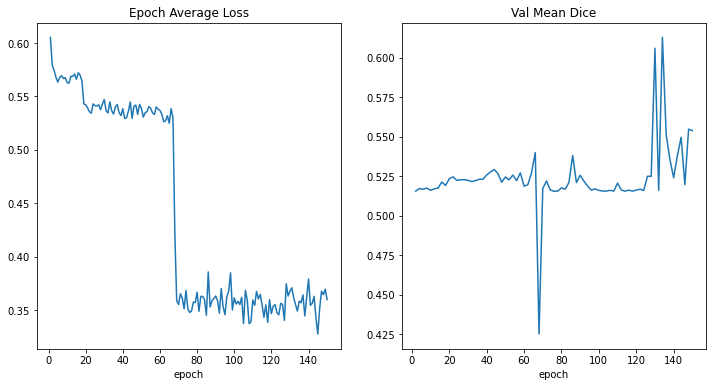

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

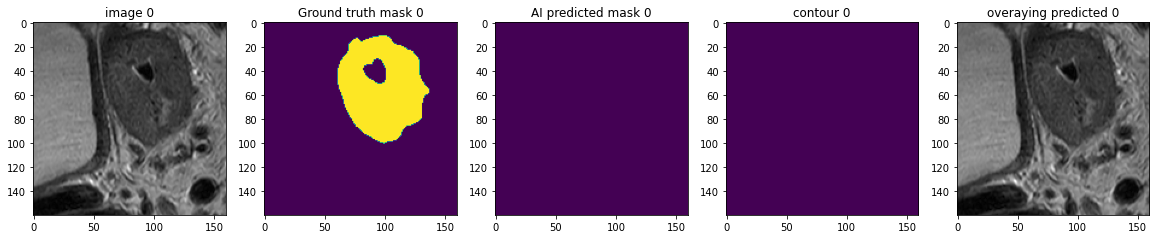

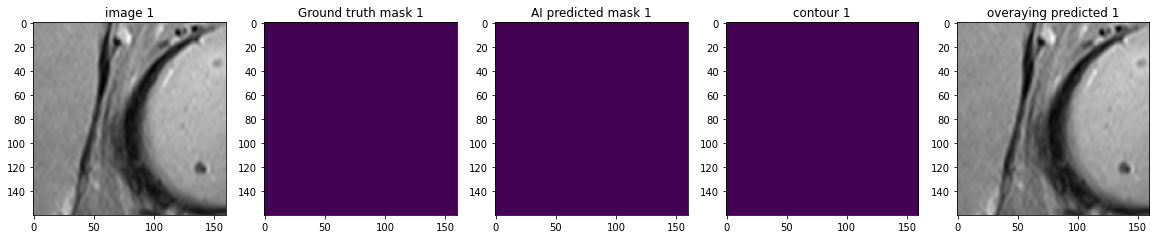

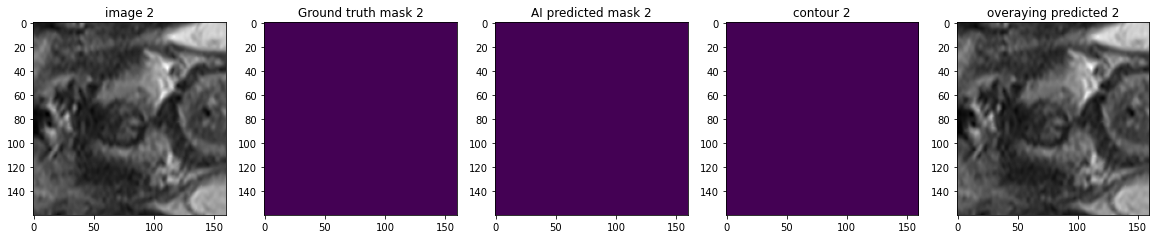

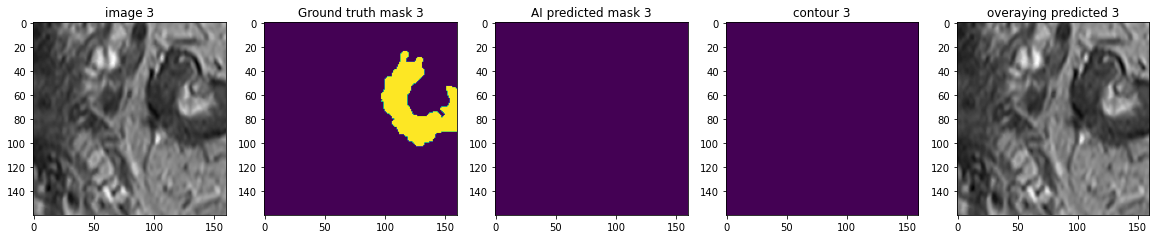

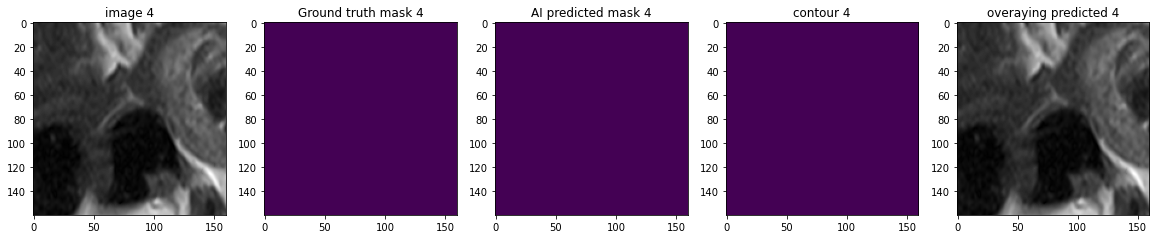

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (patch_H, patch_W, patch_D)
        sw_batch_size = 8
        test_image = test_data[0].to(device)
        test_output = sliding_window_inference(
                        test_image, roi_size, sw_batch_size, model)
        # plot the slice [:, :, rand]
        j = randint(0, len(test_image[0,0,0,0,:])-1)
        plt.figure("check", (20, 4))

        plt.subplot(1, 5, 1)
        plt.title(f"image {i}")
        plt.imshow(test_image.detach().cpu()[0, 0, :, :, j], cmap="gray")

        plt.subplot(1, 5, 2)
        plt.title(f"Ground truth mask {i}")
        plt.imshow(test_data[1][0, 0, :, :, j])

        plt.subplot(1, 5, 3)
        plt.title(f"AI predicted mask {i}")
        argmax = AsDiscrete(argmax=True)(test_output)
        plt.imshow(argmax.detach().cpu()[0, 0, :, :, j])

        plt.subplot(1, 5, 4)
        plt.title(f"contour {i}")
        contour = LabelToContour()(argmax)
        plt.imshow(contour.detach().cpu()[0, 0, :, :, j])

        plt.subplot(1, 5, 5)
        plt.title(f"overaying predicted {i}")
        map_image = test_image.clone().detach()
        map_image[argmax==1] = map_image.max()
        plt.imshow(map_image.detach().cpu()[0, 0, :, :, j], cmap="gray")
        plt.show()